In [8]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from data.data_loader import generateGauss
from utils.integral import grid
from Models.classification import Logistics
from Models.classification.Logistics import generate_gaussian_basis
from utils.vis import plot_beta, temp

In [10]:
h = 0.01
x_grid = grid(h, start=-2, end=12)

mu_A = [1, 1.5, 2, 2.5, 6]
sig_A = 0.4 * np.ones_like(mu_A)
mu_B = [4.5, 7.5, 8.5, 8, 8.5]
sig_B = 0.9 * np.ones_like(mu_A)

class1_data = generateGauss(mu_A, sig_A, x_grid)
class2_data = generateGauss(mu_B, sig_B, x_grid)
all_pdfs = np.vstack([class1_data, class2_data])

y = np.array([0]*len(class1_data) + [1]*len(class2_data))
n_A, n_B = len(class1_data), len(class2_data)
print(y)

[0 0 0 0 0 1 1 1 1 1]


In [11]:
# Logistic Regression
print("\n=== Logistic Regression ===")
M = 10
basis_functions = generate_gaussian_basis(x_grid, M)

moments = np.array([
	[np.trapezoid(f * psi, x_grid) for psi in basis_functions]
	for f in all_pdfs
])
X_design = np.hstack([np.ones((moments.shape[0], 1)), moments])

log_model = Logistics.Model(n_iter=1000, l1_penalty=.01, l2_penalty=0.001, verbose=False)
log_model.fit(X_design, y)
decision_values = log_model.predict_proba(X_design)
preds = log_model.predict(X_design)
print(preds)
acc = np.mean(preds == y)
print(f"[LOGISTIC] Accuracy: {acc*100:.2f}%")



=== Logistic Regression ===
[0 0 0 0 0 1 1 1 1 1]
[LOGISTIC] Accuracy: 100.00%


In [12]:
new_pdf = generateGauss([3], [0.9], x_grid).ravel()

moment = np.array([np.trapezoid(new_pdf * psi, x_grid) for psi in basis_functions])
X_new = np.hstack([1.0, moment])
prob = log_model.predict_proba(X_new.reshape(1, -1))[0]
pred = log_model.predict(X_new.reshape(1, -1))[0]
print(f"[LOGISTIC] New sample → Class: {pred}, Probability (class 1): {prob:.4f}")

[LOGISTIC] New sample → Class: 0, Probability (class 1): 0.4274


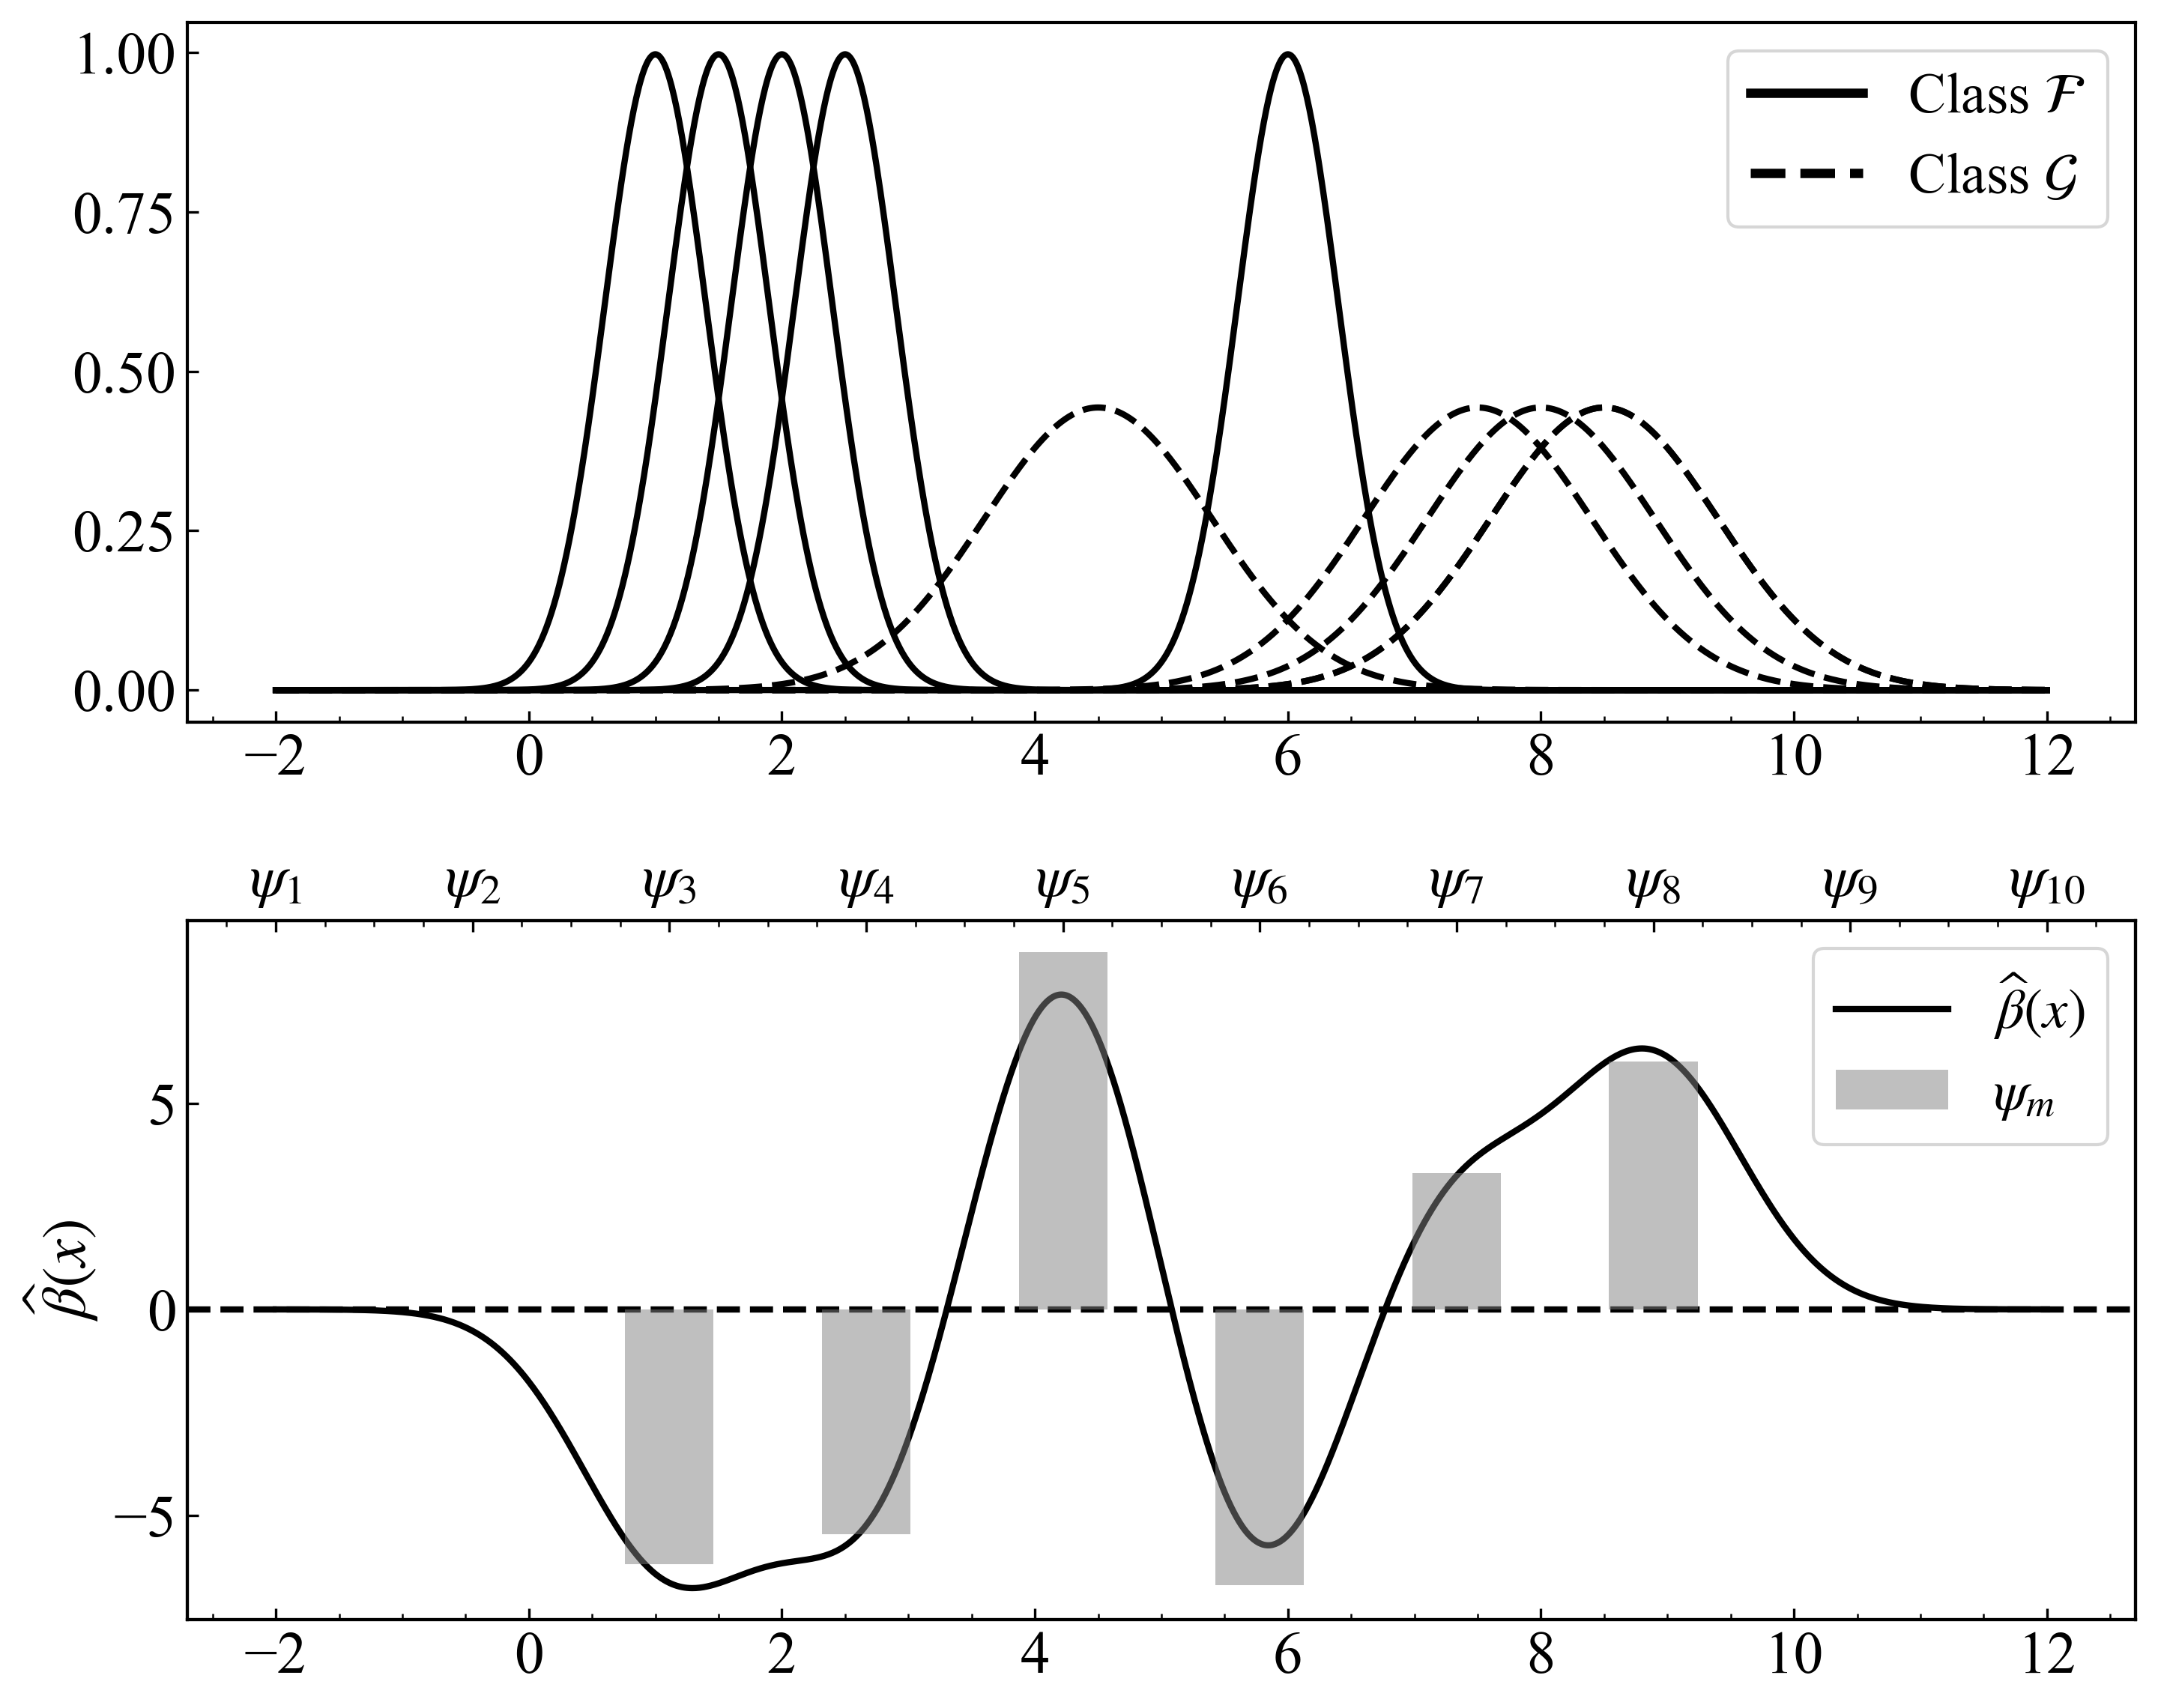

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
temp(20)
# -------------------------------------------------
# 1) PDFs in the upper row
# -------------------------------------------------
for i in range(len(all_pdfs)):
    if y[i] == 0:
        axes[0].plot(x_grid, all_pdfs[i], lw=2, color='black', linestyle='-')
    else:
        axes[0].plot(x_grid, all_pdfs[i], lw=2, color='black', linestyle='--')

# Thêm legend
axes[0].plot([], [], lw=3, color='black', linestyle='-', label=r'Class $\mathcal{F}$')
axes[0].plot([], [], lw=3, color='black', linestyle='--', label=r'Class $\mathcal{G}$')
axes[0].legend()

# -------------------------------------------------
# 2) Beta function in the lower row
# -------------------------------------------------
beta_vals = np.asarray(log_model.coef_vector_)
w = sum(b * psi for b, psi in zip(beta_vals, basis_functions))

# Main line for β̂(x)
line, = axes[1].plot(x_grid, w, color='black', lw=2, label=r'$\widehat{\beta}(x)$')
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_ylabel(r'$\widehat{\beta}(x)$')

# Secondary x-axis (top) for the basis bars
ax2 = axes[1].twiny()
M = len(beta_vals)
x_pos = np.linspace(x_grid.min(), x_grid.max(), M)
bars = ax2.bar(
    x_pos, beta_vals,
    width=(x_grid.max() - x_grid.min()) / (M * 2),
    color='gray', alpha=0.5, label=r'$\psi_m$'
)

ax2.set_xticks(x_pos)
ax2.set_xticklabels([fr'$\psi_{{{i+1}}}$' for i in range(M)])
ax2.set_xlim(axes[1].get_xlim())

# Combine legends
lines = [line, bars]
labels = [l.get_label() for l in lines]
axes[1].legend(lines, labels, loc='best')

plt.tight_layout()
fig.savefig("C1_beta_log.pdf", bbox_inches='tight')